In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
#git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [0]:
!pip install numpy==1.17.5 

In [0]:
from pycocotools import cocoeval
cocoeval.Params(iouType='bbox')

In [0]:
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional

import importlib.util


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
from os import listdir
from os.path import isfile, join
import time
import copy
import shutil
import gzip
import binascii
import zipfile
import random


from PIL import Image
from PIL import ImageDraw



#import xml.etree.ElementTree as ET
import xml.etree.cElementTree as et



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Drive imports

from google.colab import drive
drive.mount('/content/gdrive')

PATH = "gdrive/My Drive/Semester_project/"
SUB_PATH = PATH + 'Datas/Ara/'
ANNOTATION_PATH = PATH + 'Datas/Ara/Annotations/'

IMAGE_ORIGINE_PATH = SUB_PATH + 'DeepPhenoData/'
IMAGES = SUB_PATH + 'Images/'



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
DETECTION = PATH + 'Code/Detection/'

In [0]:
import sys
sys.path.append(DETECTION)


In [0]:
import utils
import transforms
import coco_eval
import engine
import coco_utils

## File processing

In [0]:
def parse_xml(path):
    tree=et.ElementTree(et.fromstring(path))
    #tree=et.parse(path)
    root=tree.getroot()
    annotation = {'filename' : root[0].text}
    for x in root.iterfind('imagesize/'):
        root1=x
        for sizes in root1.iter():
          annotation[sizes.tag] = sizes.text   

    x_coord = set()
    y_coord = set()
    for x in root.iter('object'):
        root1=x
        for poly in root1.iterfind('polygon/pt/'):
          root2=poly
          for coordinate in root2.iter():
            if (coordinate.tag == 'x'): x_coord.add(float(coordinate.text))
            if (coordinate.tag == 'y') : y_coord.add(float(coordinate.text)) 

        # Get the class    
        for name in root1.iter('name'):

          annotation[name.tag] = name.text
        #Get the subclass 
        for stage in root1.iter('attributes'):
          annotation['stage'] = stage.text

    annotation['x_min'] = min(x_coord)
    annotation['y_min'] = min(y_coord)
    annotation['x_max'] = max(x_coord)
    annotation['y_max'] = max(y_coord)

    return annotation

In [0]:
# Compile the images 

for root, dirs, files in os.walk(IMAGE_ORIGINE_PATH):  # replace the . with your starting directory
   for file in files:
      path_file = os.path.join(root,file)
      shutil.copy2(path_file,IMAGES) # change you destination dir

In [0]:
df = pd.DataFrame(columns=['filename','nrows','ncols','name','stage','x_min','y_min', 'x_max', 'y_max'])

In [0]:


for dirName, subdirList, fileList in os.walk(ANNOTATION_PATH):
    for fname in fileList:
        filepath = os.path.join(dirName,fname)
        try:
          with zipfile.ZipFile(filepath, "r") as f:
            for name in f.namelist():
              data = f.read(name)
              #path = os.path.join(filepath,name)
              dictionary = parse_xml(data)
              df = df.append(dictionary, ignore_index=True)
        except :
          continue

In [0]:
df = df.drop_duplicates(subset='filename', keep='first')
df['stage'] = df.stage.str.extract(r'Stage=(\d)')


In [0]:
df = df[df.stage != '0']
df = df.reset_index(drop=True)

In [0]:
df.stage.unique()

array(['1', '2', '3', '4', '5'], dtype=object)

In [0]:
df.to_csv(ANNOTATION_PATH +'labels.csv')

In [0]:
df = pd.read_csv(ANNOTATION_PATH +'labels.csv')

### Test val split

In [0]:
# Using pandas, code from here : https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
SEED = 25
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)

    #Index for ending 
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end

    # Split
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test


In [0]:
#Split 
df = pd.read_csv(ANNOTATION_PATH +'labels.csv')
seeds = random.sample(range(1, 200), 5)
paths = []
for i, seed in enumerate(seeds):

  train, validate, test = train_validate_test_split(df, seed= seed)
  path = {'train': ANNOTATION_PATH +'train' + str(i) + '.csv', 
          'val' : ANNOTATION_PATH +'val' + str(i) + '.csv',
          'test': ANNOTATION_PATH +'test' + str(i) + '.csv'}

#Save the splits 
  train.to_csv(path['train'])
  validate.to_csv(path['val'])
  test.to_csv(path['test'])
  paths.append(path)

In [0]:
paths

[{'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test0.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train0.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val0.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test1.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train1.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val1.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test2.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train2.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val2.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test3.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train3.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val3.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annota

## Dataset 

Things to try : 


*   Use a pretrain model and finetuning 
*   Diferent backbones 
* Finetune backbone 
* Double finetuning with other ara dataset 



In [0]:
class AraDataset(Dataset):
  def __init__(self, 
               csv_file, 
               root_dir, 
               num_classes, 
               transform=None):
      """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

      self.data = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transform
      self.num_classes = num_classes

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):

      if torch.is_tensor(idx):
          idx = idx.tolist()

        # Get image name 
      img_name = os.path.join(self.root_dir,
                                str(self.data.iloc[idx, 2]))
      #Open image 
      image = Image.open(img_name).convert("RGB")

      #Create classes 
      classe = [self.data.loc[idx, 'name']]
      labels = [self.data.loc[idx, 'stage']]
      labels = torch.as_tensor(labels, dtype=torch.int64)
      
      # Create boxes 
      boxes = [[self.data.loc[idx, 'x_min'], self.data.loc[idx, 'y_min'],
               self.data.loc[idx, 'x_max'],self.data.loc[idx, 'y_max']]]
      boxes = torch.as_tensor(boxes, dtype=torch.float32)

      image_id = torch.tensor([idx])
      area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])

      iscrowd = torch.zeros((1,), dtype=torch.int64)

      target = {}
      target["boxes"] = boxes
      target["labels"] = labels -1 
      target["image_id"] = image_id
      target["area"] = area
      target["iscrowd"] = iscrowd

      if self.transform is not None:
          image, target = self.transform(image, target)
          #boxes = self.transform(boxes)

        
      return image, target





In [0]:
df = pd.read_csv(ANNOTATION_PATH + 'train.csv')

In [0]:
img_name = os.path.join(IMAGES ,str(df.iloc[0, 1]))

In [0]:
im = Image.open(img_name)

In [0]:
 box = [(df.loc[0, 'x_min'], df.loc[0, 'y_min']),
               (df.loc[0, 'x_max'],df.loc[0, 'y_max'])]

In [0]:
draw = ImageDraw.Draw(im)
draw.rectangle(box, outline='red')
draw.text((box[0][0] +2. , box[0][1] -12.), 'Ara', fill='red')

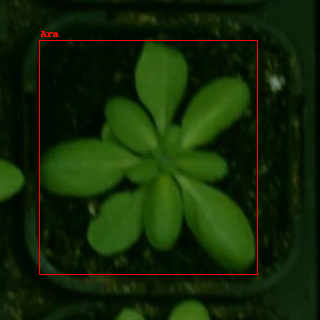

In [0]:
im

In [0]:
NUM_CLASS = 5

In [0]:
TEST =  'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test0.csv'
TRAIN =  'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train0.csv'
VAL =   'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val0.csv'


*texte en italique*## Finetunng 

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, box_nms_thresh=0.1)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    #in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    #hidden_layer = 256
    # and replace the mask predictor with a new one
   # model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
    #                                                   hidden_layer,
    #                                                   num_classes)

    return model

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = AraDataset(csv_file= TRAIN, 
                    root_dir=IMAGES,
                    num_classes=NUM_CLASS,
                    transform=get_transform(train=True))
dataset_test = AraDataset(csv_file=VAL , 
                    root_dir=IMAGES,
                    num_classes=NUM_CLASS,
                    transform=get_transform(train=False))



# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# our dataset has two classes only - background and person
num_classes = 5

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
# let's train it for 10 epochs
num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [0]:
# use our dataset and defined transformations

dataset_val = AraDataset(csv_file= TEST, #ANNOTATION_PATH + 'test.csv' ,
                    root_dir=IMAGES,
                    num_classes=NUM_CLASS,
                    transform=get_transform(train=False))

In [0]:
SUB_PATH

'gdrive/My Drive/Semester_project/Datas/Ara/'

In [0]:
image = Image.open(SUB_PATH + 'test.jpg').convert("RGB")

In [0]:
transform = transforms.Compose([
 
        transforms.ToTensor(),
    ])

In [0]:
trans = transforms.functional.to_tensor(image)

AttributeError: ignored

In [0]:
# From : http://ronny.rest/tutorials/module/localization_001/iou/ 

def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou


In [0]:
vec = np.zeros(len(dataset_val))
per_class = np.zeros((len(dataset_val), 5))
up_class = np.zeros(5)
down_class = np.zeros(5)
nbr_per_class = np.zeros( 5)

iou = np.zeros(len(dataset_val))
t_class = np.zeros(len(dataset_val))
pred_classes = np.zeros(len(dataset_val))
neb = np.zeros(len(dataset_val))

In [0]:
confusion_matrix = torch.zeros(NUM_CLASS, NUM_CLASS)

for i, img in enumerate(dataset_val): 
  true_class = img[1]['labels'].numpy()[0]
  model.eval()
  prediction = model([img[0].to(device)])
  try : 
    pred_box = prediction[0]['boxes'].cpu().detach().numpy()[0]
    pred_class = prediction[0]['labels'].cpu().detach().numpy()[0]
  except: 
    pred_box = 0
    pred_class = 0 
  for t, p in zip(img[1]['labels'][0].view(-1), prediction[0]['labels'].cpu().detach().view(-1)):
            confusion_matrix[t.long(), p.long()] += 1 
  t_class[i] = int(true_class)
  pred_classes[i] = int(pred_class)           
  
  nbr_per_class[true_class] += 1
  if true_class == pred_class : 
    vec[i] = 1
    per_class[i,true_class] = 1
  if true_class == pred_class +1 : 
    down_class[true_class] +=1

  if true_class == pred_class -1 : 
    up_class[true_class] += 1

  if (true_class == pred_class or true_class == pred_class + 1 or true_class == pred_class -1) : 
    neb[i] = 1
  try : 
    iou[i] = get_iou(prediction[0]['boxes'].cpu().detach().numpy()[0], img[1]['boxes'].cpu().numpy()[0])
  except : 
    iou[i] = 0



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [0]:
# pick one image from the test set
img, val = dataset_val[43]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [0]:
np.count_nonzero(vec == 1)/len(vec)


0.6876513317191283

In [0]:
np.mean(per_class, axis=0)

array([0.00242131, 0.18401937, 0.15496368, 0.14769976, 0.19854722])

In [0]:
confusion_matrix

tensor([[ 0., 33.,  3.,  0.,  0.],
        [ 0., 76., 16.,  0.,  0.],
        [ 0., 14., 64., 17.,  0.],
        [ 0.,  0., 15., 61., 14.],
        [ 0.,  0.,  0., 17., 82.]])

In [0]:
color =  ['#ffffff', '#e6e9eb', '#cdd3d7', '#b4bec4', '#9ca9b1',
'#85949e', '#6e808c', '#576d7a', '#415a69', '#2a4858' ]

tensor([[ 0., 33.,  3.,  0.,  0.],
        [ 0., 76., 16.,  0.,  0.],
        [ 0., 14., 64., 17.,  0.],
        [ 0.,  0., 15., 61., 14.],
        [ 0.,  0.,  0., 17., 82.]])
tensor([0.0000, 0.8261, 0.6737, 0.6778, 0.8283])
tensor([0.0000, 0.8261, 0.6737, 0.6778, 0.8283])
tensor([   nan, 0.6179, 0.6531, 0.6421, 0.8542])
tensor(0.6869)


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:407: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


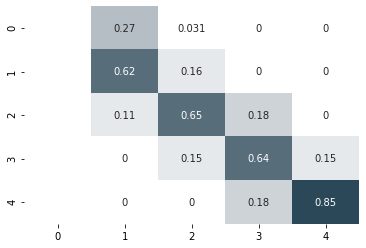

In [0]:
print(confusion_matrix)
sns.heatmap(confusion_matrix /  confusion_matrix.sum(0),annot=True, cbar=False, cmap=color)
print(confusion_matrix.diag() / confusion_matrix.sum(1))
precision  =  np.diag(confusion_matrix)/ confusion_matrix.T.sum(0)
recall = np.diag(confusion_matrix) / confusion_matrix.sum(0)
print(precision)
print(recall)
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

In [0]:
per_class = np.count_nonzero(per_class == 1 , axis=0)

In [0]:
per_class

array([ 1, 76, 64, 61, 82])

In [0]:
per_class/ nbr_per_class

array([0.        , 0.81      , 0.7311828 , 0.64485981, 0.8902439 ])

In [0]:
up_class 

array([31., 18., 18., 16.,  0.])

In [0]:
down_class

array([ 0.,  0.,  7., 22.,  9.])

In [0]:
up_class + down_class

array([31., 18., 25., 38.,  9.])

In [0]:
np.mean(vec)

0.7046004842615012

In [0]:
class_vector = np.zeros(6)
iou_vector = np.zeros(6)
for i, cl in enumerate(pred_classes):
  class_vector[int(cl)] += 1
  iou_vector[int(cl)] += iou[i]

In [0]:
iou_vector/class_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.        , 0.93691832, 0.9430998 , 0.94288977, 0.9281383 ,
              nan])

In [0]:
iou.mean()

0.9354492462186609

In [0]:
np.count_nonzero(neb == 1 )/ len(vec)

0.9951573849878934

In [0]:
test = torchvision.ops.nms(prediction[0]['boxes'], prediction[0]['scores'], 0.9)

In [0]:
import sklearn
from sklearn import metrics 

In [0]:
val[1]['boxes'][0]

tensor([ 11.,  19., 320., 303.])

In [0]:
prediction[0]['boxes'].cpu().detach().numpy()[0].tolist()

[14.69272518157959, 18.801549911499023, 315.4353942871094, 313.6091003417969]

In [0]:
get_iou(prediction[0]['boxes'].cpu().detach().numpy()[0], val[1]['boxes'].cpu().numpy()[0])

0.9385166169647514

In [0]:
test

tensor([0], device='cuda:0')

In [0]:
img =Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [0]:
prediction[0]['scores']

tensor([0.8214, 0.4533, 0.2363, 0.1961, 0.1911, 0.1636, 0.1448, 0.1339, 0.1212,
        0.1195, 0.0970, 0.0955, 0.0641], device='cuda:0')

In [0]:
draw = ImageDraw.Draw(img)
draw.rectangle(val['boxes'].numpy(), outline='red')
draw.text((val['boxes'].numpy()[0,0] +2. , val['boxes'].numpy()[0,1] -12.), 'Ara', fill='red')

In [0]:
final = torchvision.ops.nms(val['boxes'], val['scores'], iou_threshold)

KeyError: ignored

In [0]:
prediction[0]['labels'].cpu().numpy()[IDX]

NameError: ignored

In [0]:
IDX = 0
draw = ImageDraw.Draw(img)
draw.rectangle(prediction[0]['boxes'].cpu().numpy()[IDX], outline='red')
draw.text((prediction[0]['boxes'].cpu().numpy()[IDX,0] +2. , prediction[0]['boxes'].cpu().numpy()[IDX,1] -12.),
          str(prediction[0]['labels'].cpu().numpy()[IDX]), fill='red')

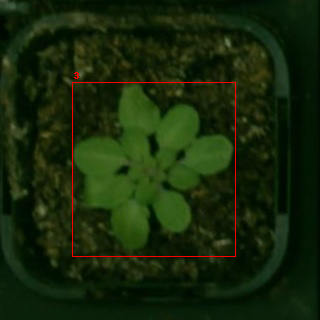

In [0]:
img

In [0]:
## Experimenting 

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = AraDataset(csv_file=ANNOTATION_PATH + 'train.csv' ,
                    root_dir=IMAGES,
                    num_classes=NUM_CLASS,
                    transform=get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
